# **Traffic Junction Queue Simulation**
Dependencies to run this project<br>
cycler==0.11.0 <br>
fonttools==4.31.2 <br>
kiwisolver==1.4.2 <br>
**matplotlib==3.5.1**<br>
**numpy==1.22.3** <br>
packaging==21.3 <br>
**pandas==1.4.1** <br>
Pillow==9.0.1 <br>
pyparsing==3.0.7 <br>
python-dateutil==2.8.2 <br>
pytz==2022.1 <br>
**scipy==1.8.0** <br>
**seaborn==0.11.2**<br>
**simpy==4.0.1**<br>
six==1.16.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Input analysis

In [2]:
rng = np.random.default_rng(188)
mean_interarrival_time = 2.0
interarrival_times = rng.exponential(scale=mean_interarrival_time, size=100)

## Interarrival times

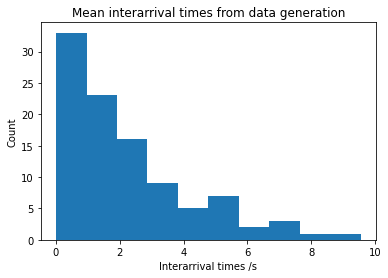

In [3]:
plt.title("Mean interarrival times from data generation")
plt.xlabel("Interarrival times /s")
plt.ylabel("Count")
plt.hist(interarrival_times, bins = 10)
plt.show()

In [4]:
inter_df = pd.DataFrame(interarrival_times, columns =['Interarrival Times Generated'])

In [5]:
inter_df

,Interarrival Times Generated
0,0.217571
1,6.814716
2,4.503782
3,2.352911
4,1.780066
...,...
95,2.770833
96,1.659786
97,1.241287
98,2.093538


In [6]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

normalised_interarrival_times = NormalizeData(interarrival_times)

In [7]:
np.sort(normalised_interarrival_times)

array([0.00000000e+00, 6.04556558e-04, 2.09268538e-03, 2.65869060e-03,
       9.81647709e-03, 1.44937657e-02, 1.80892329e-02, 1.98502618e-02,
       2.20227781e-02, 2.23224971e-02, 2.30524299e-02, 2.38143163e-02,
       2.65635380e-02, 2.88158478e-02, 3.23652646e-02, 3.73602069e-02,
       3.76879811e-02, 3.85188491e-02, 4.17945408e-02, 4.21480881e-02,
       4.50949097e-02, 5.01171097e-02, 5.39933579e-02, 5.68228273e-02,
       6.58494068e-02, 6.62872554e-02, 7.04276845e-02, 7.60237254e-02,
       7.74696910e-02, 7.82283169e-02, 7.88132903e-02, 7.99692919e-02,
       9.15593315e-02, 1.08343080e-01, 1.09237990e-01, 1.09562173e-01,
       1.16140786e-01, 1.29632904e-01, 1.32276596e-01, 1.48042368e-01,
       1.51215721e-01, 1.60390945e-01, 1.62842045e-01, 1.64994785e-01,
       1.65952155e-01, 1.67516415e-01, 1.69332214e-01, 1.70097347e-01,
       1.73501733e-01, 1.74619012e-01, 1.77984103e-01, 1.78926771e-01,
       1.80786846e-01, 1.86110066e-01, 1.89861841e-01, 1.98556748e-01,
      

In [8]:
df = pd.DataFrame(normalised_interarrival_times, columns =['Normalised Interarrival Times Generated'])

In [9]:
df

,Normalised Interarrival Times Generated
0,0.022322
1,0.713864
2,0.471622
3,0.246158
4,0.186110
...,...
95,0.289967
96,0.173502
97,0.129633
98,0.218970


In [10]:
from scipy.stats import kstest

#perform Kolmogorov-Smirnov test
kstest(normalised_interarrival_times, 'expon')

KstestResult(statistic=0.48859775717212917, pvalue=1.5760547288472525e-22)

In [11]:
#significant value at 0.05
import math
alpha = 1.36/ math.sqrt(100)

In [12]:
alpha

0.136

## Trying with poisson distribution

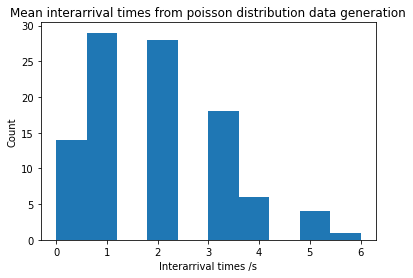

In [13]:
mean_interarrival_time = 2.0
interarrival_times = rng.poisson(mean_interarrival_time, 100)
arrival_times = np.cumsum(interarrival_times)
plt.title("Mean interarrival times from poisson distribution data generation")
plt.xlabel("Interarrival times /s")
plt.ylabel("Count")
plt.hist(interarrival_times, bins = 10)
plt.show()

In [14]:
from scipy.stats import kstest
kstest(interarrival_times, 'norm')

KstestResult(statistic=0.7013447460685429, pvalue=7.25280331628819e-50)

## Delay times

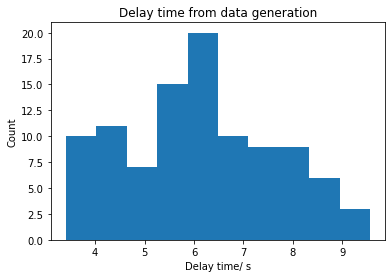

In [15]:
delay_times = rng.triangular(left=3.0, mode=5.0, right=10.0, size= 100)

plt.title("Delay time from data generation")
plt.xlabel("Delay time/ s")
plt.ylabel("Count")
plt.hist(delay_times, bins = 10)
plt.show()

In [16]:
from scipy.stats import kstest
#perform Kolmogorov-Smirnov test
kstest(delay_times, 'norm')

KstestResult(statistic=0.9996705810332608, pvalue=0.0)

# Simulation

## Simulation model

In [17]:
from collections import deque
from simpy import *
import numpy as np
import pandas as pd
# model by Tee Wen Shi
# List of dependencies
# cycler==0.11.0
# fonttools==4.31.2
# kiwisolver==1.4.2
# matplotlib==3.5.1
# numpy==1.22.3
# packaging==21.3
# pandas==1.4.1
# Pillow==9.0.1
# pyparsing==3.0.7
# python-dateutil==2.8.2
# pytz==2022.1
# scipy==1.8.0
# seaborn==0.11.2
# simpy==4.0.1
# six==1.16.0


# T_INTERARRIVAL_MEAN = 3
# T_GREEN = 30
# T_RED = 100
# T_YELLOW = 0
# YELLOW_START = T_RED + T_GREEN
# T_SIMULATION = 1000
# T_CYCLE = T_RED + T_GREEN + T_YELLOW
# SEED = 188
DEPARTURE_CONSTANT = 3

class Vehicle(object):
    def __init__(self, name, arrivaltime): 
        self.name = name
        self.arrival_time = arrivaltime          

    def __str__(self):
        return "vehicle: %d arrival time: %s " % (self.name, convert_second(self.arrival_time))


class Traffic_intersection(object):
    def __init__(self, env: Environment, green, red):
        self.env = env       
        self.right_lane = deque()
        self.straight_lane = deque()
        self.departure_times = []
        self.green_time = green
        self.red_time = red 
        self.traffic_cycle_time = green + red           
        self.red_light_event = self.env.process(self.traffic_light()) 
        self.right_queue_count = [[],[]]    
        self.straight_queue_count = [[],[]]   
              
    def departure(self, lane: deque[Vehicle]):
        # queue not empty
        # first car departure
        if(lane):            
            yield self.env.timeout(vehicle_delay())
            #append to the departure times
            self.departure_times.append(self.env.now)
            vehicle = lane.popleft()
            print("vehicle no %s depart at %-20s" % (vehicle.name, convert_second(self.env.now)) ) 
        while True:
            time = self.env.now % self.traffic_cycle_time            
            if(time >= self.red_time and lane):
                vehicle = lane.popleft()
                yield self.env.timeout(DEPARTURE_CONSTANT)
                self.departure_times.append(self.env.now)
                print("vehicle no %s depart at %-20s" % (vehicle.name, convert_second(self.env.now)) )               
            else:
                #adjust back the green light time
                adjust = abs(time - self.traffic_cycle_time)
                yield self.env.timeout(adjust)                
                return             
        
    def traffic_light(self):       
        while True:            
            print("\n\nRed light: %s" % convert_second(self.env.now))
            #red light              
            yield self.env.timeout(self.red_time)
            self.record_queue()
                                      
            #green light  
            print("\n\nGreen light: %s" % convert_second(self.env.now))
            
            # start departure           
            yield self.env.process(self.departure(self.right_lane)) & self.env.process(self.departure(self.straight_lane))
            self.check_queue()
            
    def set_lane(self):
        right_lane = np.random.choice([True, False], p=[0.6, 0.4])
        if(right_lane):
            return self.right_lane, "right"
        else:
            return self.straight_lane, "straight"

    def check_queue(self):
        print("%d vehicles still in right lane" % len(self.right_lane))
        print("%d vehicles still in straight lane" % len(self.straight_lane))

    def record_queue(self):
        self.right_queue_count[0].append(len(self.right_lane))
        self.right_queue_count[1].append(self.env.now)
        self.straight_queue_count[0].append(len(self.straight_lane))
        self.straight_queue_count[1].append(self.env.now)

    def queue_data_frame(self):
        squeue_df = pd.DataFrame({
            "No of vehicles in queue": self.straight_queue_count[0],
                "Time recorded /s": self.straight_queue_count[1],
        })

        rqueue_df = pd.DataFrame({
            "No of vehicles in queue": self.right_queue_count[0],
                "Time recorded /s": self.right_queue_count[1],
        })
        return squeue_df, rqueue_df

def arrival(env: Environment, traffic_light: Traffic_intersection, array, lane, mean):
    arrival_count = 0 
      
    while True:       
        interarrival_time = np.random.exponential(mean)
        arrival_count += 1
        array.append(interarrival_time)
        lane_queue, name_of_lane = traffic_light.set_lane() 
        lane.append(name_of_lane)       
        yield env.timeout(interarrival_time)
        print("vehicle no %d arrival %-20s" % (arrival_count, convert_second(env.now)))        
        lane_queue.append(Vehicle(arrival_count, env.now))        
        

        
def vehicle_delay():
    
    return np.random.triangular(3, 5, 10)

def convert_second(seconds):
    if(seconds <= 60):
        return "%5.3f s" % seconds
    elif(seconds >= 3600):
        min, sec = divmod(seconds, 60)
        hr, min = divmod(min, 60)
        return "%d h %d min %5.3f s" % (hr, min, sec)
    else:
        min, sec = divmod(seconds, 60)
        return "%d min %5.3f s" % (min, sec)

def main(seed_value, mean=3, green_light_time= 30, red_light_time= 100, run_length=1000):        
    env = Environment()      
    tr = Traffic_intersection(env, green_light_time, red_light_time)    
    np.random.seed(seed_value)  
    interarrival_times = []
    lane = []
    env.process(arrival(env, tr, interarrival_times, lane, mean))   
    env.run(until=run_length)  
    tr.check_queue()
    
      
    
    #data processing
    
    arrival_times = np.cumsum(interarrival_times)
    departure_times = np.array(tr.departure_times)
    new_dep = np.resize(departure_times, arrival_times.shape[0]) 
    new_dep[departure_times.size:] = np.nan
    wait_times = np.subtract(new_dep,arrival_times)
    lane = np.array(lane)

    #pandas data frame
    vehicles_df = pd.DataFrame({
            "interarrival_time": interarrival_times,
            "arrive_time": arrival_times,
            "departure_time": new_dep,            
            "wait_time": wait_times,  
            "lane_entered": lane          
        })
    
    tr.queue_data_frame()

    straight_queue, right_queue =tr.queue_data_frame()
    

    print("finished simulation")
    return vehicles_df, straight_queue, right_queue

In [18]:
#run simulation 1
#seed = 188
#interarrival mean = 3
#green light time = 30 s
#red light time = 100 s
#simulation time = 1000 s
sim1, straight1, right1 = main(188, 3, 40, 100, 1000)



Red light: 0.000 s
vehicle no 1 arrival 2.152 s             
vehicle no 2 arrival 4.620 s             
vehicle no 3 arrival 9.585 s             
vehicle no 4 arrival 10.526 s            
vehicle no 5 arrival 10.743 s            
vehicle no 6 arrival 14.944 s            
vehicle no 7 arrival 18.082 s            
vehicle no 8 arrival 19.085 s            
vehicle no 9 arrival 22.348 s            
vehicle no 10 arrival 24.351 s            
vehicle no 11 arrival 24.726 s            
vehicle no 12 arrival 25.609 s            
vehicle no 13 arrival 25.884 s            
vehicle no 14 arrival 30.099 s            
vehicle no 15 arrival 33.625 s            
vehicle no 16 arrival 36.322 s            
vehicle no 17 arrival 38.280 s            
vehicle no 18 arrival 38.598 s            
vehicle no 19 arrival 48.328 s            
vehicle no 20 arrival 49.010 s            
vehicle no 21 arrival 55.634 s            
vehicle no 22 arrival 55.925 s            
vehicle no 23 arrival 56.898 s            

In [19]:
pd.set_option('display.max_rows', None)
sim1

,interarrival_time,arrive_time,departure_time,wait_time,lane_entered
0,2.152182,2.152182,106.009440,103.857258,straight
1,2.467323,4.619505,107.864661,103.245156,right
2,4.965413,9.584918,109.009440,99.424522,right
3,0.941010,10.525928,110.864661,100.338733,right
4,0.217505,10.743434,112.009440,101.266006,straight
5,4.200391,14.943825,113.864661,98.920836,straight
6,3.137683,18.081508,115.009440,96.927932,straight
7,1.003378,19.084886,116.864661,97.779775,straight
8,3.263073,22.347958,118.009440,95.661481,right
9,2.002882,24.350840,119.864661,95.513820,right


In [20]:
grp = sim1.groupby(by=["lane_entered"])

In [21]:
grp["interarrival_time"].describe()

,count,mean,std,min,25%,50%,75%,max
lane_entered,,,,,,,,
right,195.0,3.336922,2.914066,0.027922,1.014950,2.558005,4.745828,12.222833
straight,130.0,2.692744,2.433055,0.001654,0.829632,1.917388,4.057682,12.566297


In [22]:
grp["arrive_time"].describe()

,count,mean,std,min,25%,50%,75%,max
lane_entered,,,,,,,,
right,195.0,485.530248,285.844178,4.619505,243.170357,463.824951,729.905080,1000.756557
straight,130.0,492.590592,295.671551,2.152182,254.132894,466.973980,743.645851,994.868698


In [23]:
grp["wait_time"].describe()

,count,mean,std,min,25%,50%,75%,max
lane_entered,,,,,,,,
right,65.0,407.909846,224.335163,80.335036,279.145770,464.309107,668.699702,711.047755
straight,39.0,364.575344,210.411191,81.940155,189.141348,307.530539,501.015316,699.396790


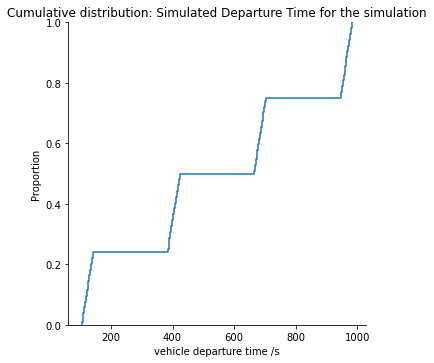

In [24]:
import seaborn as sns
sns.displot(sim1, x="departure_time", kind="ecdf").set(title='Cumulative distribution: Simulated Departure Time for the simulation').set(xlabel= "vehicle departure time /s")

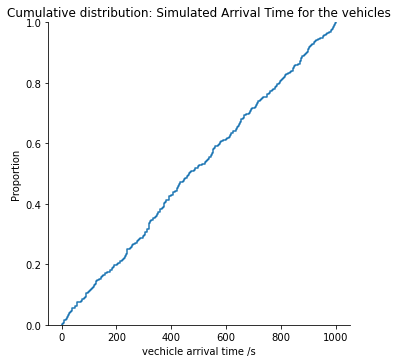

In [25]:
sns.displot(sim1, x="arrive_time", kind="ecdf").set(title='Cumulative distribution: Simulated Arrival Time for the vehicles').set(xlabel="vechicle arrival time /s")

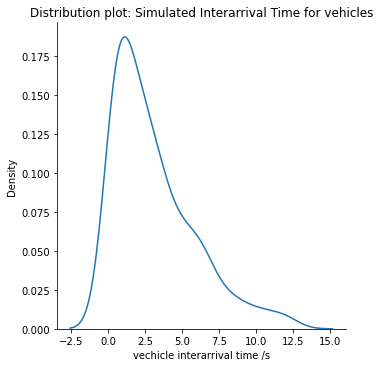

In [26]:
sns.displot(sim1, x="interarrival_time", kind="kde").set(title='Distribution plot: Simulated Interarrival Time for vehicles').set(xlabel="vechicle interarrival time /s")

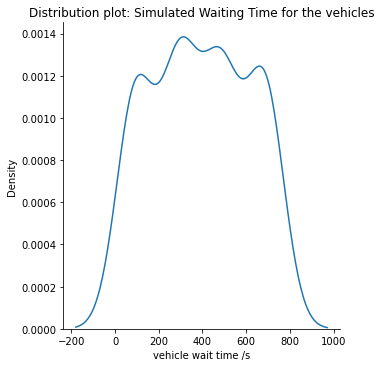

In [27]:
sns.displot(sim1, x="wait_time", kind="kde").set(xlabel="vehicle wait time /s", title='Distribution plot: Simulated Waiting Time for the vehicles')

## Output analysis

In [28]:
sim1

,interarrival_time,arrive_time,departure_time,wait_time,lane_entered
0,2.152182,2.152182,106.009440,103.857258,straight
1,2.467323,4.619505,107.864661,103.245156,right
2,4.965413,9.584918,109.009440,99.424522,right
3,0.941010,10.525928,110.864661,100.338733,right
4,0.217505,10.743434,112.009440,101.266006,straight
5,4.200391,14.943825,113.864661,98.920836,straight
6,3.137683,18.081508,115.009440,96.927932,straight
7,1.003378,19.084886,116.864661,97.779775,straight
8,3.263073,22.347958,118.009440,95.661481,right
9,2.002882,24.350840,119.864661,95.513820,right


In [29]:
sim1.describe()

,interarrival_time,arrive_time,departure_time,wait_time
count,325.000000,325.000000,104.000000,104.000000
mean,3.079251,488.354385,546.831353,391.659408
std,2.746165,289.382167,312.366075,219.200297
min,0.001654,2.152182,106.009440,80.335036
25%,0.948032,248.224811,386.130437,275.815080
50%,2.318500,463.824951,544.002083,388.646644
75%,4.548494,731.147720,763.559382,553.142848
max,12.566297,1000.756557,982.574424,711.047755


In [30]:
import matplotlib.pyplot as plt
def plot_histogram(data, title, xlabel):
    plt.figure(figsize=(14, 4))
    plt.title(title, size=18)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.hist(data, bins=50)
    plt.show()

In [31]:
sim1.loc[:,"interarrival_time"]

0       2.152182
1       2.467323
2       4.965413
3       0.941010
4       0.217505
5       4.200391
6       3.137683
7       1.003378
8       3.263073
9       2.002882
10      0.375250
11      0.882569
12      0.274842
13      4.215117
14      3.526881
15      2.696374
16      1.958432
17      0.318046
18      9.729342
19      0.682543
20      6.623408
21      0.290862
22      0.973101
23      1.220762
24      3.556035
25      7.848867
26      4.026125
27      2.773818
28      4.743857
29      2.675612
30      4.451132
31      0.139790
32      0.016294
33      0.708919
34      6.675628
35      4.548494
36      2.150992
37      3.092432
38      1.251611
39      3.745625
40      2.793614
41      4.584916
42      1.799944
43      0.541654
44      3.776692
45      0.407784
46      0.641818
47      3.634521
48      6.468851
49      8.487380
50      0.073892
51      4.778963
52      0.886941
53      2.172052
54      6.800663
55      1.287180
56      6.985518
57      8.539636
58      2.6952

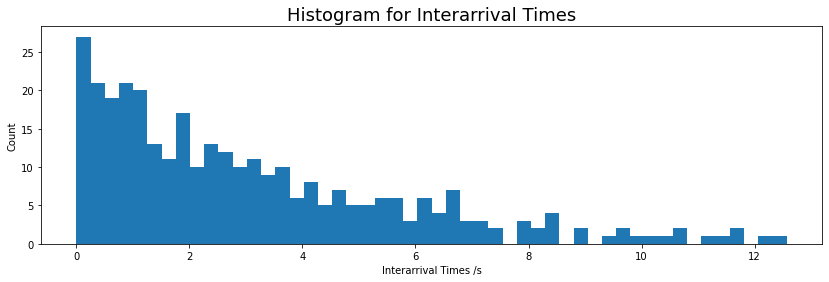

In [32]:
plot_histogram(sim1.loc[:,"interarrival_time"], "Histogram for Interarrival Times", "Interarrival Times /s")

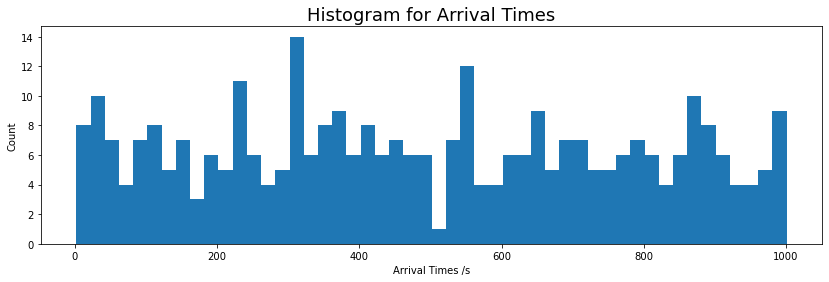

In [33]:
plot_histogram(sim1.loc[:,"arrive_time"], "Histogram for Arrival Times", "Arrival Times /s")

In [34]:
#run simulation 2
#seed = 188
#interarrival mean = 3
#green light time = 40 s
#red light time = 100 s
#simulation time = 1000 s
sim2, straight2, right2 = main(188, 3, 40, 100, 1000)



Red light: 0.000 s
vehicle no 1 arrival 2.152 s             
vehicle no 2 arrival 4.620 s             
vehicle no 3 arrival 9.585 s             
vehicle no 4 arrival 10.526 s            
vehicle no 5 arrival 10.743 s            
vehicle no 6 arrival 14.944 s            
vehicle no 7 arrival 18.082 s            
vehicle no 8 arrival 19.085 s            
vehicle no 9 arrival 22.348 s            
vehicle no 10 arrival 24.351 s            
vehicle no 11 arrival 24.726 s            
vehicle no 12 arrival 25.609 s            
vehicle no 13 arrival 25.884 s            
vehicle no 14 arrival 30.099 s            
vehicle no 15 arrival 33.625 s            
vehicle no 16 arrival 36.322 s            
vehicle no 17 arrival 38.280 s            
vehicle no 18 arrival 38.598 s            
vehicle no 19 arrival 48.328 s            
vehicle no 20 arrival 49.010 s            
vehicle no 21 arrival 55.634 s            
vehicle no 22 arrival 55.925 s            
vehicle no 23 arrival 56.898 s            

In [35]:
sim2

,interarrival_time,arrive_time,departure_time,wait_time,lane_entered
0,2.152182,2.152182,106.009440,103.857258,straight
1,2.467323,4.619505,107.864661,103.245156,right
2,4.965413,9.584918,109.009440,99.424522,right
3,0.941010,10.525928,110.864661,100.338733,right
4,0.217505,10.743434,112.009440,101.266006,straight
5,4.200391,14.943825,113.864661,98.920836,straight
6,3.137683,18.081508,115.009440,96.927932,straight
7,1.003378,19.084886,116.864661,97.779775,straight
8,3.263073,22.347958,118.009440,95.661481,right
9,2.002882,24.350840,119.864661,95.513820,right


In [36]:
sim2.describe()

,interarrival_time,arrive_time,departure_time,wait_time
count,325.000000,325.000000,104.000000,104.000000
mean,3.079251,488.354385,546.831353,391.659408
std,2.746165,289.382167,312.366075,219.200297
min,0.001654,2.152182,106.009440,80.335036
25%,0.948032,248.224811,386.130437,275.815080
50%,2.318500,463.824951,544.002083,388.646644
75%,4.548494,731.147720,763.559382,553.142848
max,12.566297,1000.756557,982.574424,711.047755


In [37]:
grp2 = sim2.groupby(by=["lane_entered"])
grp2["wait_time"].describe()

,count,mean,std,min,25%,50%,75%,max
lane_entered,,,,,,,,
right,65.0,407.909846,224.335163,80.335036,279.145770,464.309107,668.699702,711.047755
straight,39.0,364.575344,210.411191,81.940155,189.141348,307.530539,501.015316,699.396790


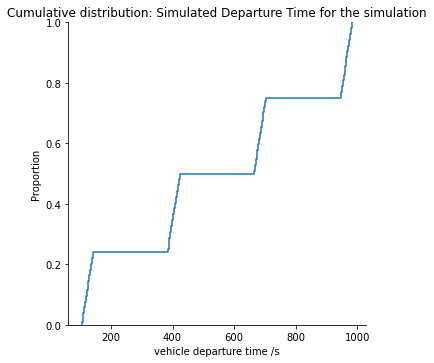

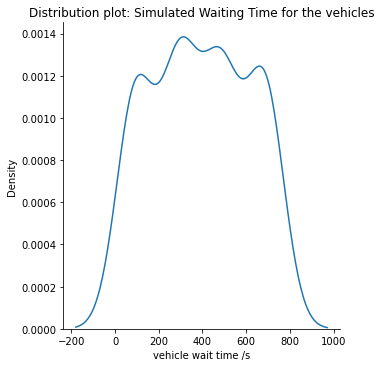

In [38]:
#data analysis
import seaborn as sns
sns.displot(sim2, x="departure_time", kind="ecdf").set(title='Cumulative distribution: Simulated Departure Time for the simulation').set(xlabel= "vehicle departure time /s")
sns.displot(sim2, x="wait_time", kind="kde").set(xlabel="vehicle wait time /s", title='Distribution plot: Simulated Waiting Time for the vehicles')

In [39]:
#run simulation 3
#seed = 188
#interarrival mean = 3
#green light time = 40 s
#red light time = 60 s
#simulation time = 1000 s
sim3, straight3, right3 = main(188, 3, 30, 60, 1000)



Red light: 0.000 s
vehicle no 1 arrival 2.152 s             
vehicle no 2 arrival 4.620 s             
vehicle no 3 arrival 9.585 s             
vehicle no 4 arrival 10.526 s            
vehicle no 5 arrival 10.743 s            
vehicle no 6 arrival 14.944 s            
vehicle no 7 arrival 18.082 s            
vehicle no 8 arrival 19.085 s            
vehicle no 9 arrival 22.348 s            
vehicle no 10 arrival 24.351 s            
vehicle no 11 arrival 24.726 s            
vehicle no 12 arrival 25.609 s            
vehicle no 13 arrival 25.884 s            
vehicle no 14 arrival 30.099 s            
vehicle no 15 arrival 33.625 s            
vehicle no 16 arrival 36.322 s            
vehicle no 17 arrival 38.280 s            
vehicle no 18 arrival 38.598 s            
vehicle no 19 arrival 48.328 s            
vehicle no 20 arrival 49.010 s            
vehicle no 21 arrival 55.634 s            
vehicle no 22 arrival 55.925 s            
vehicle no 23 arrival 56.898 s            

In [40]:
sim3

,interarrival_time,arrive_time,departure_time,wait_time,lane_entered
0,2.152182,2.152182,66.024793,63.872611,straight
1,2.467323,4.619505,68.400758,63.781254,right
2,4.965413,9.584918,69.024793,59.439875,right
3,0.941010,10.525928,71.400758,60.874830,right
4,0.217505,10.743434,72.024793,61.281359,straight
5,4.200391,14.943825,74.400758,59.456934,straight
6,3.137683,18.081508,75.024793,56.943285,straight
7,1.003378,19.084886,77.400758,58.315873,straight
8,3.263073,22.347958,78.024793,55.676834,right
9,2.002882,24.350840,80.400758,56.049918,right


In [41]:
sim3.describe()

,interarrival_time,arrive_time,departure_time,wait_time
count,324.000000,324.000000,116.000000,116.000000
mean,3.098381,481.594061,538.088176,369.701304
std,2.776635,288.173053,307.100198,205.529649
min,0.001654,2.152182,66.024793,51.744488
25%,0.949151,240.211172,261.150459,189.506476
50%,2.360590,456.389928,605.969855,401.700688
75%,4.557600,723.227924,800.242293,546.276651
max,12.566297,1003.875319,992.406117,672.611191


In [42]:
grp3 = sim3.groupby(by=["lane_entered"])
grp3["wait_time"].describe()

,count,mean,std,min,25%,50%,75%,max
lane_entered,,,,,,,,
right,69.0,377.188301,207.087551,51.744488,192.333002,403.169484,546.658325,672.611191
straight,47.0,358.709755,204.946275,56.302140,189.182003,320.993812,543.296999,670.476379


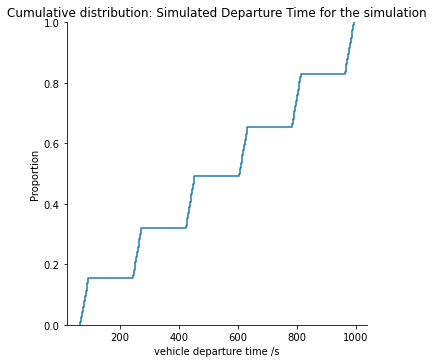

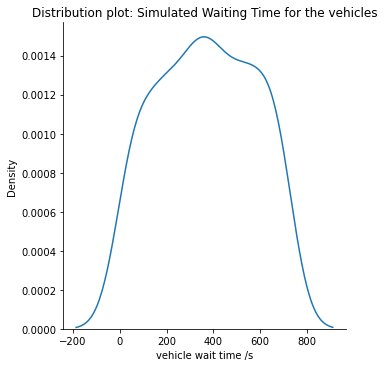

In [43]:
#data analysis
import seaborn as sns
sns.displot(sim3, x="departure_time", kind="ecdf").set(title='Cumulative distribution: Simulated Departure Time for the simulation').set(xlabel= "vehicle departure time /s")
sns.displot(sim3, x="wait_time", kind="kde").set(xlabel="vehicle wait time /s", title='Distribution plot: Simulated Waiting Time for the vehicles')


In [44]:
#run simulation 4
#seed = 188
#interarrival mean = 3
#green light time = 40 s
#red light time = 80 s
#simulation time = 1000 s
sim4, straight4, right4 = main(188, 3, 40, 80, 1000)



Red light: 0.000 s
vehicle no 1 arrival 2.152 s             
vehicle no 2 arrival 4.620 s             
vehicle no 3 arrival 9.585 s             
vehicle no 4 arrival 10.526 s            
vehicle no 5 arrival 10.743 s            
vehicle no 6 arrival 14.944 s            
vehicle no 7 arrival 18.082 s            
vehicle no 8 arrival 19.085 s            
vehicle no 9 arrival 22.348 s            
vehicle no 10 arrival 24.351 s            
vehicle no 11 arrival 24.726 s            
vehicle no 12 arrival 25.609 s            
vehicle no 13 arrival 25.884 s            
vehicle no 14 arrival 30.099 s            
vehicle no 15 arrival 33.625 s            
vehicle no 16 arrival 36.322 s            
vehicle no 17 arrival 38.280 s            
vehicle no 18 arrival 38.598 s            
vehicle no 19 arrival 48.328 s            
vehicle no 20 arrival 49.010 s            
vehicle no 21 arrival 55.634 s            
vehicle no 22 arrival 55.925 s            
vehicle no 23 arrival 56.898 s            

In [45]:
sim4

,interarrival_time,arrive_time,departure_time,wait_time,lane_entered
0,2.152182,2.152182,86.212377,84.060195,straight
1,2.467323,4.619505,88.937303,84.317799,right
2,4.965413,9.584918,89.212377,79.627459,right
3,0.941010,10.525928,91.937303,81.411375,right
4,0.217505,10.743434,92.212377,81.468943,straight
5,4.200391,14.943825,94.937303,79.993479,straight
6,3.137683,18.081508,95.212377,77.130869,straight
7,1.003378,19.084886,97.937303,78.852418,straight
8,3.263073,22.347958,98.212377,75.864418,right
9,2.002882,24.350840,100.937303,76.586463,right


In [46]:
sim4.describe()

,interarrival_time,arrive_time,departure_time,wait_time
count,326.000000,326.000000,103.000000,103.000000
mean,3.099323,488.437108,467.700455,314.301643
std,2.787261,289.541467,268.702222,176.622524
min,0.001654,2.152182,86.212377,60.537973
25%,0.944773,248.712571,325.833310,218.448747
50%,2.304441,462.936402,564.742802,364.782430
75%,4.575811,731.874915,704.456698,473.562389
max,12.566297,1010.379361,842.764741,572.380077


In [47]:
grp4 = sim4.groupby(by=["lane_entered"])
grp4["wait_time"].describe()

,count,mean,std,min,25%,50%,75%,max
lane_entered,,,,,,,,
right,64.0,322.019901,178.844471,60.537973,218.552304,365.749243,530.504279,572.380077
straight,39.0,301.635784,174.476419,63.012798,156.715151,252.266037,414.040225,569.487470


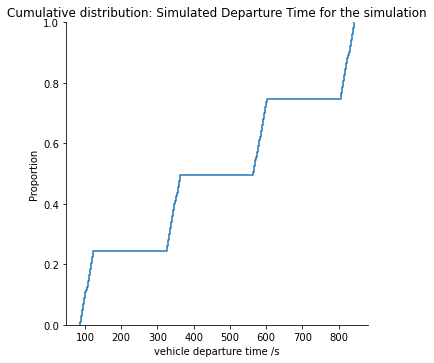

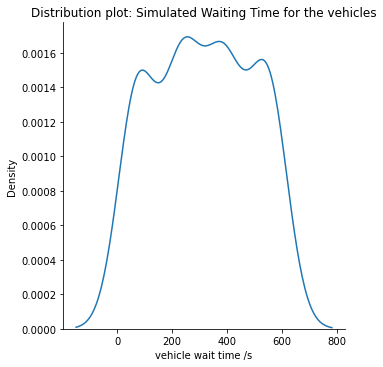

In [48]:
#data analysis
import seaborn as sns
sns.displot(sim4, x="departure_time", kind="ecdf").set(title='Cumulative distribution: Simulated Departure Time for the simulation').set(xlabel= "vehicle departure time /s")
sns.displot(sim4, x="wait_time", kind="kde").set(xlabel="vehicle wait time /s", title='Distribution plot: Simulated Waiting Time for the vehicles')


## Point estimates

### Confidence interval for interarrival time

In [49]:
sim1["departure_time"]

0      106.009440
1      107.864661
2      109.009440
3      110.864661
4      112.009440
5      113.864661
6      115.009440
7      116.864661
8      118.009440
9      119.864661
10     121.009440
11     122.864661
12     124.009440
13     125.864661
14     127.009440
15     128.864661
16     130.009440
17     131.864661
18     133.009440
19     134.864661
20     136.009440
21     137.864661
22     139.009440
23     140.864661
24     142.009440
25     383.880437
26     386.880437
27     386.939069
28     389.880437
29     389.939069
30     392.880437
31     392.939069
32     395.880437
33     395.939069
34     398.880437
35     398.939069
36     401.880437
37     401.939069
38     404.880437
39     404.939069
40     407.880437
41     407.939069
42     410.880437
43     410.939069
44     413.880437
45     413.939069
46     416.880437
47     416.939069
48     419.880437
49     419.939069
50     422.880437
51     422.939069
52     665.065097
53     666.691289
54     668.065097
55     669

In [50]:
import scipy.stats as st

#retreive the sample interarrival data from the simulation 1
data = sim1["interarrival_time"].to_numpy()
data = data[np.logical_not(np.isnan(data))]

#create 95% confidence interval for population departure time
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 


(2.779570507560421, 3.3789313827891014)

In [51]:
data.mean()

3.079250945174761

In [52]:
# two tailled 
# 0.05 /2 = 0.025
pvalue = st.t.ppf(1-0.025, df=len(data)-1)
pvalue

1.9673127716990169

In [53]:
sterr = st.sem(data)
sterr

0.15232983891805324

In [54]:
pvalue * sterr

0.2996804376143401

### Confidence interval for waiting time

In [55]:
sim1["wait_time"]

0      103.857258
1      103.245156
2       99.424522
3      100.338733
4      101.266006
5       98.920836
6       96.927932
7       97.779775
8       95.661481
9       95.513820
10      96.283350
11      97.256002
12      98.125939
13      95.766043
14      93.383941
15      92.542788
16      91.729135
17      93.266311
18      84.681747
19      85.854425
20      80.375796
21      81.940155
22      82.111833
23      82.746292
24      80.335036
25     314.357167
26     313.331042
27     310.615856
28     308.813367
29     306.196387
30     304.686623
31     304.605464
32     307.530539
33     306.880251
34     303.145992
35     298.656130
36     299.446506
37     296.412705
38     298.102463
39     294.415470
40     294.563224
41     290.036939
42     291.178364
43     290.695341
44     289.860017
45     289.510864
46     291.810414
47     288.234524
48     284.707042
49     276.278294
50     279.145770
51     274.425439
52     515.664526
53     515.118666
54     509.691811
55     510

In [56]:
#retreive the sample waiting time data from the simulation 1
data = sim1["wait_time"].to_numpy()
data = data[np.logical_not(np.isnan(data))]

#create 95% confidence interval for population waiting time
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

(349.0304194116943, 434.2883965911949)

In [57]:
data.mean()

391.6594080014446

In [58]:
# two tailled
# 0.05 /2 = 0.025
pvalue = st.t.ppf(1-0.025, df=len(data)-1)
pvalue

1.98326414470971

In [59]:
sterr = st.sem(data)
sterr

21.494357523409914

In [60]:
pvalue * sterr

42.62898858975028

## Confidence interval for number of vehicles in queue
Number of vehicles in queue is measured before every green light cycle

## In the straight lane

In [61]:
straight1

,No of vehicles in queue,Time recorded /s
0,14,100.0
1,42,380.0
2,61,660.0
3,85,940.0


In [62]:
data = straight1["No of vehicles in queue"].to_numpy()

#create 95% confidence interval for no of vehicles in queue
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

(2.7191252219422566, 98.28087477805775)

In [63]:
data.mean()

50.5

In [64]:
# two tailled
# 0.05 /2 = 0.025
pvalue = st.t.ppf(1-0.025, df=len(data)-1)
pvalue

3.182446305284263

In [65]:
sterr = st.sem(data)
sterr

15.013882464794596

In [66]:
pvalue * sterr

47.78087477805774

## In the right lane

In [67]:
right1

,No of vehicles in queue,Time recorded /s
0,21,100.0
1,65,380.0
2,108,660.0
3,144,940.0


In [68]:
data = right1["No of vehicles in queue"].to_numpy()

#create 95% confidence interval for no of vehicles in queue
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

(-0.22422811371534124, 169.22422811371536)

In [69]:
data.mean()

84.5

In [70]:
# two tailled test 
# 0.05 /2 = 0.025
pvalue = st.t.ppf(1-0.025, df=len(data)-1)
pvalue

3.182446305284263

In [71]:
sterr = st.sem(data)
sterr

26.622359023948274

In [72]:
pvalue * sterr

84.72422811371534